In [43]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Pkg
using IJulia


In [44]:
ENV["COLUMNS"] = 200;

In [45]:
# Assuming your Julia file is named "COVIDResourceAllocation.jl"
include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation


In [46]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)
travel_threshold_hours = 4.0;

In [47]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [48]:
adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [49]:
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
);

In [50]:
demand = forecast_active * Float32(nurse_days_per_patient_day_covid);

In [51]:
nurses = n_nurses(states) * Float32(pct_nurses_available);

In [52]:
_nurses_beds = n_nurses(states, source=:beds);
_nurses_empl = n_nurses(states, source=:employment);
_nurses_ahrf = n_nurses(states, source=:ahrf);
DataFrame(
    state = states,
    from_beds = _nurses_beds,
    from_empl = _nurses_empl,
    from_ahrf = _nurses_ahrf,
)

Row,state,from_beds,from_empl,from_ahrf
,String,Float32,Float32,Float32
1,CT,8221.27,12120.0,4593.0
2,DE,2257.27,3234.06,1322.0
3,MA,17563.5,38220.5,10146.0
4,MD,9598.4,29581.0,6169.0
5,ME,2877.47,2346.56,1962.0
6,NH,2567.13,1484.33,1934.0
7,NJ,19164.1,71498.5,6652.0
8,NY,44213.9,83342.8,19547.0
9,PA,34385.9,65427.3,14189.0


In [53]:
model = reusable_resource_allocation(
    nurses,
    zeros(Float32, size(demand)...),
    demand,
    adj,
    send_new_only=false,
    sendrecieve_switch_time=0,
    min_send_amt=0,
    smoothness_penalty=0,
    setup_cost=0,
    sent_penalty=0.01,
    verbose=true
)
sent = value.(model[:sent])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13358 rows, 12276 columns and 1922589 nonzeros
Model fingerprint: 0x662872d4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+04]
Presolve removed 11313 rows and 5550 columns
Presolve time: 0.62s
Presolved: 2045 rows, 6726 columns, 1073367 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...


Barrier performed 0 iterations in 0.82 seconds (0.48 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     961    2.288

In [54]:
results = NurseAllocationResults.results_all(sent, nurses, demand, states, start_date);

In [55]:
println("Total sent: ", results.total_sent)
println("Total shortage: ", results.total_shortage)
println("Average load: ", results.average_load)

Total sent: 29078.47764968872
Total shortage: 213563.32621765137
Average load: 0.7864897040552088


In [56]:
results.summary_table

Row,state,total_sent,total_received,initial_nurses,total_nurse_days,total_demand,total_shortage,average_load
,String,Float64,Float64,Float32,Float64,Float32,Float64,Float64
1,CT,2135.31,3119.67,2296.5,2.8191e5,1.76364e5,18737.2,0.680954
2,DE,555.537,237.098,661.0,26748.2,19446.9,821.993,0.811411
3,MA,4709.08,2181.88,5073.0,206885.0,1.2986e5,12652.9,0.730141
4,MD,1873.89,1980.21,3084.5,263024.0,2.10661e5,11908.3,0.862183
5,ME,933.554,0.0,981.0,5840.98,5125.24,194.956,0.985538
6,NH,881.276,206.49,967.0,20684.5,19925.0,896.508,1.01597
7,NJ,5.2998,6018.34,3326.0,8.25678e5,5.47443e5,54508.1,0.684629
8,NY,11581.5,11323.2,9773.5,1.11123e6,7.85759e5,74068.7,0.607139
9,PA,5546.13,3506.35,7094.5,3.91898e5,2.75288e5,37901.3,0.932099


In [57]:
results.sent_matrix_table

Row,state,CT,DE,MA,MD,ME,NH,NJ,NY,PA,RI,VT
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,0.0,0.0,0.0,0.0,0.0,166.498,1968.82,0.0,0.0,0.0,0.0
2,DE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,555.537,0.0,0.0,0.0
3,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4709.08,0.0,0.0,0.0
4,MD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1873.89,0.0,0.0,0.0
5,ME,533.814,0.0,246.084,0.0,0.0,32.9065,0.0,0.0,0.0,120.75,0.0
6,NH,881.276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NJ,0.0,3.61273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68707,0.0
8,NY,1704.58,233.485,1632.36,1980.21,0.0,0.0,2141.79,0.0,3506.35,382.77,0.0
9,PA,0.0,0.0,0.0,0.0,0.0,0.0,1361.4,4184.73,0.0,0.0,0.0


In [59]:
s = "NY"
filter(row -> row.state == s, results.complete_table)


Row,state,date,sent,received,initial_nurses,current_nurses,demand,shortage,load,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float64,Float64,Any,Any
1,NY,2020-03-30,0.0,7146.78,9773.5,16920.3,13320.6,0.0,0.787259,[],"[(""DE"", 555.537), (""MA"", 4709.08), (""MD"", 1873.89), (""PA"", 8.27366)]"
2,NY,2020-03-31,0.0,0.0,9773.5,16920.3,15116.9,0.0,0.89342,[],[]
3,NY,2020-04-01,0.0,4176.45,9773.5,21096.7,16920.3,0.0,0.802033,[],"[(""PA"", 4176.45)]"
4,NY,2020-04-02,0.0,0.0,9773.5,21096.7,18678.3,0.0,0.885364,[],[]
5,NY,2020-04-03,0.0,0.0,9773.5,21096.7,20323.2,0.0,0.963336,[],[]
6,NY,2020-04-04,0.0,0.0,9773.5,21096.7,21804.5,707.788,1.03355,[],[]
7,NY,2020-04-05,0.0,0.0,9773.5,21096.7,23066.7,1970.01,1.09338,[],[]
8,NY,2020-04-06,0.0,0.0,9773.5,21096.7,24089.6,2992.85,1.14186,[],[]
9,NY,2020-04-07,0.0,0.0,9773.5,21096.7,24835.1,3738.4,1.1772,[],[]


In [60]:
df = results.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Shortage=df.shortage)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
shortage_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    shortage_matrix[i, :] .= state_df.Shortage
end

# check the shortage matrix
size(shortage_matrix)

(11, 93)

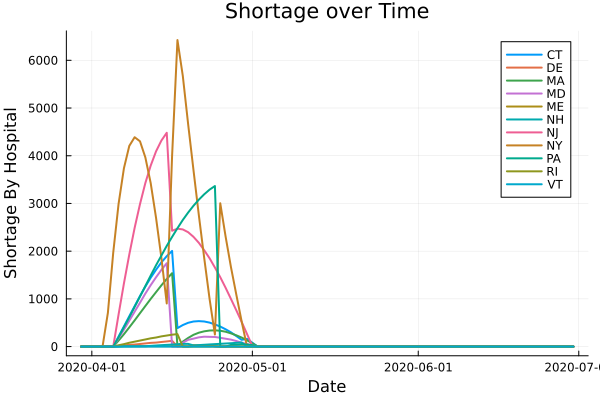

In [61]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

net_shortage = shortage_matrix
date_range = start_date:end_date
plot(date_range, [vec(net_shortage[i,:]) for i in 1:size(net_shortage)[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "Historical_shortage_plot.png"))

In [68]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Nurse Transfer By Hospital",
     title = "Total Nurse Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "NA_NSent_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/NA_NSent_plot.png"

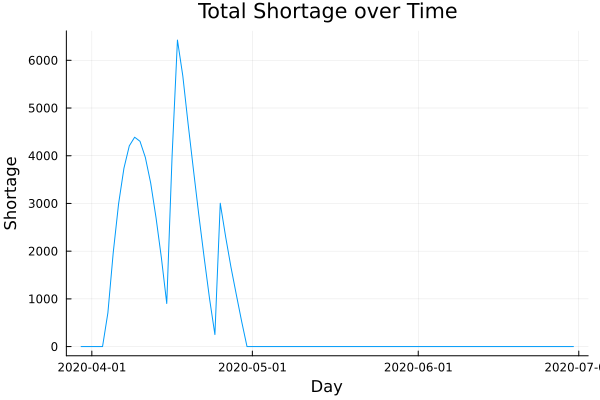

In [39]:
using Plots
shortage_values = df.shortage
days = df.date

# Plot the time series
plot(days, shortage_values, xlabel="Day", ylabel="Shortage", title="Total Shortage over Time", legend=false)

In [35]:
results.sent_to

Dict{String, Vector{String}} with 11 entries:
  "RI" => ["NJ"]
  "NY" => ["CT", "DE", "MA", "MD", "NJ", "PA", "RI"]
  "ME" => ["CT", "MA", "NH", "RI"]
  "NJ" => ["DE", "RI"]
  "DE" => ["NY"]
  "MD" => ["NY"]
  "NH" => ["CT"]
  "CT" => ["NH", "NJ"]
  "MA" => ["NY"]
  "PA" => ["NJ", "NY"]
  "VT" => ["MA", "NH"]